In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [8]:
df = pd.read_csv('train_data_w_macro.csv')
test = pd.read_csv('test_data_w_macro.csv')
df.head()

,storey_range,floor_area_sqm,lease_months_left,resale_price,date,gdp in chained (2015) dollars,assets,liabilities,mas core inflation measure,m_from2017,town_tampines,town_punggol,town_sembawang,town_choa chu kang,town_sengkang,flat_model_Apartment,flat_model_DBSS,flat_model_Maisonette
0,0.1875,0.059633,736,232000.0,2017-01-01,111034.4,1985339.9,326458.6,96.763,0.0,0,0,0,0,0,0,0,0
1,0.0000,0.165138,727,250000.0,2017-01-01,111034.4,1985339.9,326458.6,96.763,0.0,0,0,0,0,0,0,0,0
2,0.0000,0.165138,749,262000.0,2017-01-01,111034.4,1985339.9,326458.6,96.763,0.0,0,0,0,0,0,0,0,0
3,0.0625,0.169725,745,265000.0,2017-01-01,111034.4,1985339.9,326458.6,96.763,0.0,0,0,0,0,0,0,0,0
4,0.0000,0.165138,749,265000.0,2017-01-01,111034.4,1985339.9,326458.6,96.763,0.0,0,0,0,0,0,0,0,0


In [9]:
df1 = df.groupby('date').mean().reset_index()
test1 = test.groupby('date').mean().reset_index()
df1.head()

,date,storey_range,floor_area_sqm,lease_months_left,resale_price,gdp in chained (2015) dollars,assets,liabilities,mas core inflation measure,m_from2017,town_tampines,town_punggol,town_sembawang,town_choa chu kang,town_sengkang,flat_model_Apartment,flat_model_DBSS,flat_model_Maisonette
0,2017-01-01,0.126010,0.296851,882.396259,427378.211735,111034.4,1985339.9,326458.6,96.763,0.000000,0.069728,0.045918,0.019558,0.037415,0.068027,0.034864,0.008503,0.021259
1,2017-02-01,0.131771,0.309493,893.960185,447295.950926,111034.4,1985339.9,326458.6,96.836,0.010526,0.062963,0.052778,0.029630,0.042593,0.075926,0.045370,0.010185,0.033333
2,2017-03-01,0.139161,0.303472,894.871361,444852.246628,111034.4,1985339.9,326458.6,96.883,0.021053,0.061938,0.064055,0.024881,0.036527,0.077819,0.040762,0.012176,0.026998
3,2017-04-01,0.131624,0.303007,894.477210,438553.120066,113218.7,2012412.8,329965.5,97.332,0.031579,0.069193,0.054366,0.026359,0.036244,0.071389,0.036244,0.010434,0.026359
4,2017-05-01,0.139725,0.304657,897.469148,443663.258542,113218.7,2012412.8,329965.5,97.177,0.042105,0.066803,0.051504,0.029577,0.034676,0.077002,0.034676,0.017338,0.028557


In [10]:
# set date as the index column
df1.set_index('date', inplace=True)
test1.set_index('date', inplace=True)


In [11]:
# Fitting a VAR model
model = VAR(df1)


/Users/Athena/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [12]:
# Determining the optimal lag order
lag_order_results = model.select_order(maxlags=3)
print(lag_order_results.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -30.10      -29.64   8.444e-14      -29.91
1      -52.03     -43.64*   2.763e-23     -48.64*
2      -52.83      -36.52   2.259e-23      -46.25
3     -55.61*      -31.38  9.142e-24*      -45.83
-------------------------------------------------


In [13]:
best_lag = lag_order_results.aic

In [14]:
model_fitted = model.fit(best_lag)
print(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 16, Apr, 2025
Time:                     16:20:06
--------------------------------------------------------------------
No. of Equations:         17.0000    BIC:                   -31.3766
Nobs:                     92.0000    HQIC:                  -45.8278
Log likelihood:           1222.73    FPE:                9.14161e-24
AIC:                     -55.6077    Det(Omega_mle):     4.50042e-27
--------------------------------------------------------------------
Results for equation storey_range
                                      coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------
const                                    0.236787         0.275420            0.860           0.390
L1.storey_range                          0.026392         0.193915           

In [15]:
forecast_steps = len(test1)
forecast_input = df1.values[-best_lag:]

forecast = model_fitted.forecast(y=forecast_input, steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, index=test1.index, columns=test1.columns)

In [16]:
target = 'resale_price'
y_true = test1[target]
y_pred = forecast_df[target]

# evaluate model
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: 48887.769381075625
RMSE: 49540.05174956784


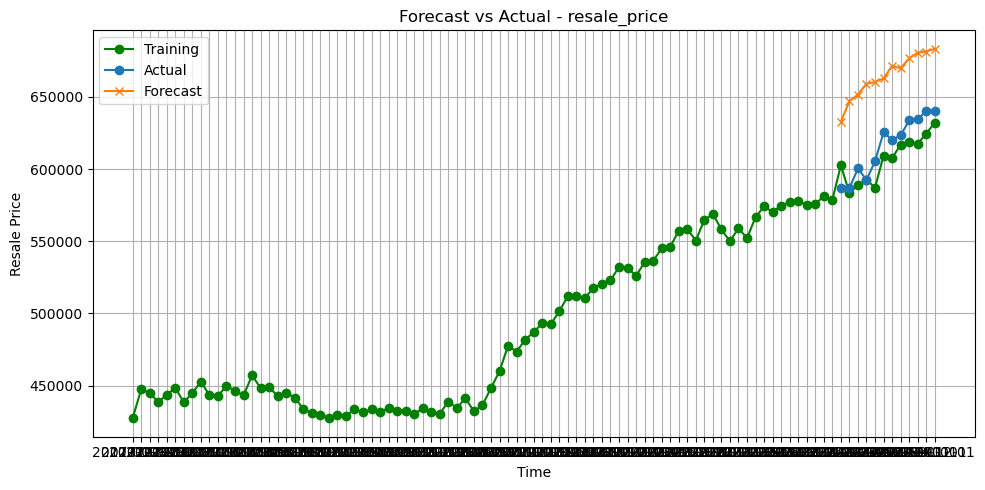

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(df1.index, df1[target], label='Training', color = 'green', marker='o')
plt.plot(test1.index, y_true, label='Actual', marker='o')
plt.plot(forecast_df.index, y_pred, label='Forecast', marker='x')
plt.title(f"Forecast vs Actual - {target}")
plt.xlabel("Time")
plt.ylabel("Resale Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## use xgboost to improve model performance

In [18]:
import xgboost as xgb

In [19]:
ignore = ['date', 'resale_price']
features = [col for col in df.columns if col not in ignore]

# Train model
model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=5)
model.fit(df1[features], df1[target])

# Predict
y_pred = model.predict(test1[features])
y_true = test1[target]

In [20]:
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"XGBoost MAE: {mae:.2f}")
print(f"XGBoost RMSE: {rmse:.2f}")


XGBoost MAE: 26066.54
XGBoost RMSE: 26773.47


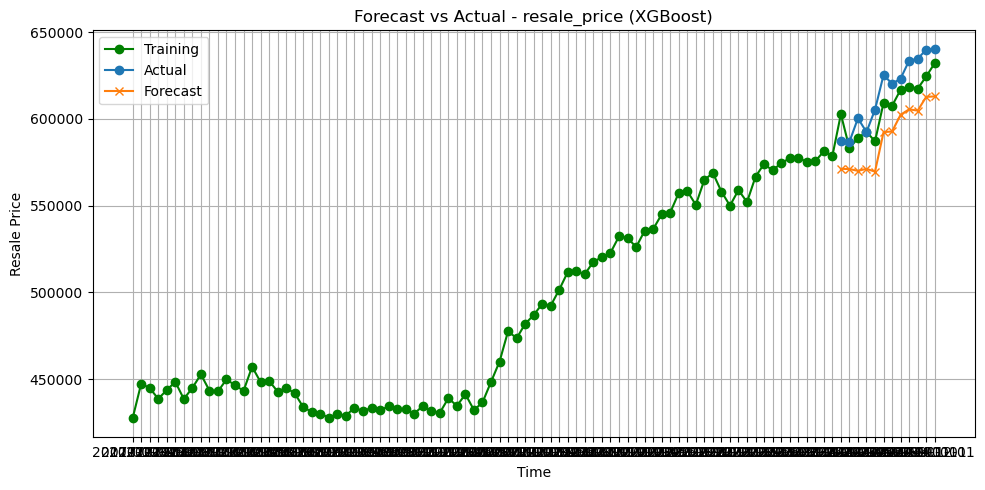

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(df1.index, df1[target], label='Training', color = 'green', marker='o')
plt.plot(test1.index, y_true, label='Actual', marker='o')
plt.plot(forecast_df.index, y_pred, label='Forecast', marker='x')
plt.title(f"Forecast vs Actual - {target} (XGBoost)")
plt.xlabel("Time")
plt.ylabel("Resale Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

can do hyperparameter tuning for better perf